# Figure generation

In [1]:
# clone repository 
#!git clone https://github.com/mtcarilli/GCCP_2022.git

In [2]:
#!pip install numdifftools

In [3]:
# clone and install color palette
#!git clone https://github.com/BlakeRMills/MetBrewer.git
#!pip install ./MetBrewer/Python

In [1]:
import numpy as np
import pandas as pd
from torchsummary import summary
import scipy
from scipy import stats
import time

import ypred_module as ypm
import exact_cme as cme
import train_conditional as train
import tools_conditional as tools
import direct_module as direct


import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import rcParams
from matplotlib import ticker
rcParams['axes.titlepad'] = 20 
plt.rcParams.update({'font.size': 27})

import met_brewer
from met_brewer import met_brew

import seaborn as sns
sns.set_theme(style = "white", font_scale= 1.6)

In [4]:
# a e s t h e t i c s
fs = 14
n = 123

-----

# Figure 1: Approximation Overview


### Figure 2: Conditional distributions

Plotting for 5 kernel functions for ease of visualization. 

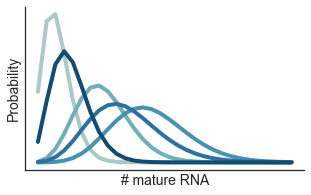

In [5]:
k = np.arange(0,30)

# can play around with the values for different shapes
ns = [20,30,30,15,15,20]
ps = [0.9,0.8,0.7,0.6,0.8,0.9]

fig1,ax1 = plt.subplots(1,1,figsize=(5,3))

colors = ("#abc9c8", "#72aeb6", "#4692b0", "#2f70a1", "#134b73", "#0a3351")
for i in range(5):
    P = scipy.stats.nbinom.pmf(k, ns[i], ps[i], loc=0)
    plt.plot(P,'-',c=colors[i],linewidth=4)

plt.xticks([])
plt.yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

plt.xlabel('# mature RNA',fontsize=fs)
plt.ylabel('Probability',fontsize=fs)

plt.savefig('./figs/kernels.png',dpi=450)

### Figure 2: Conditional

Use the Approximation for 2b.

In [5]:
# met_brew(name="Greek", n=n, brew_type="continuous").reverse()

/Users/mariacarilli/grad/git/pachter/GCCP_2022/ypred_module.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  index = torch.tensor(m_range+1,dtype=torch.long)


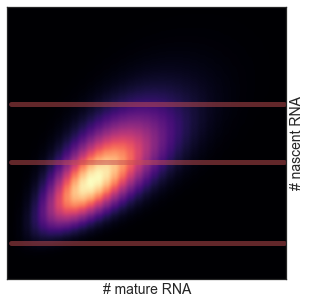

In [6]:
p_vec = np.log10(np.array([10,.1,.8]))

# cmap=LinearSegmentedColormap.from_list('cm', met_brew(name="Peru2", n=n, brew_type="continuous"), N=n)
# cmap='Wistia'
# cmap='summer'
# cmap=LinearSegmentedColormap.from_list('cm', met_brew(name="VanGogh3", n=n, brew_type="continuous")[::-1], N=n)
cmap='magma'
# cmap='spring'
# [::-1]

p, true = cme.calculate_exact_cme(p_vec,method='quad_vec',xmax_fun=tools.xmax_fun) 
pred = tools.predict_full_pmf(p_vec,true,model=ypm.model)

fig1,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(5,5))

vmax = np.max(np.concatenate((pred.flatten(),true.flatten())))
vmin = np.min(np.concatenate((pred.flatten(),true.flatten())))

# ax1[0].imshow(true,aspect='auto',vmin=vmin,vmax=vmax)

hell_ = tools.hellinger(pred.flatten(),true.flatten())

ax1.imshow(pred,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap)
ax1.invert_yaxis()
ax1.yaxis.set_label_position("right")

ax1.set_xlabel('# mature RNA',fontsize=fs)
ax1.set_ylabel('# nascent RNA',fontsize=fs)

desired_conditionals = [30,100,150]
for i in range(len(desired_conditionals)):
    plt.plot([0,pred.shape[1]-0.8],[desired_conditionals[i]]*2,alpha=0.5,linewidth=5,color='r')

ax1.set_xticks([])
ax1.set_yticks([])
plt.savefig('./figs/approx_pmf.png',dpi=450)

### Conditionals for plots in 2c

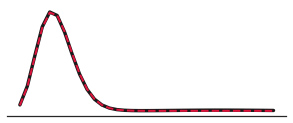

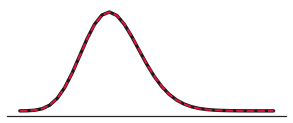

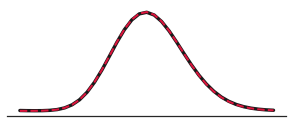

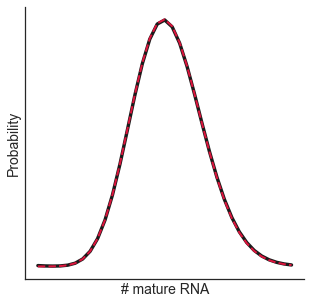

In [7]:
i=0
# lw=
for cond in desired_conditionals:
    fig1,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(5,2))
    plt.plot(true[cond,:],'k-',label='True PMF',linewidth=3.4)
    plt.plot(pred[cond,:],color='crimson',label='Approximated PMF',linewidth=2,linestyle='--')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    # plt.xlabel('# mature RNA')
    # plt.ylabel('Probability')
    plt.savefig('./figs/cond{:.0f}.png'.format(i),dpi=450)
    i+=1
    # # plt.title(f'P (m | n = {cond})',fontsize=20)
    # plt.legend()
fig1,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(5,5))
plt.plot(true[cond,:],'k-',label='True PMF',linewidth=3.4)
plt.plot(pred[cond,:],color='crimson',label='Approximated PMF',linewidth=2,linestyle='--')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(True)

plt.xlabel('# mature RNA',fontsize=fs)
plt.ylabel('Probability',fontsize=fs)
plt.savefig('./figs/condbig{:.0f}.png'.format(i),dpi=450)


In [8]:
#!zip  figs.zip ./figs/* 

-----
# Figure 2 : Performance



### Figure 2a: Time vs. Hellinger Distance 
Plotting timing vs. hellinger distance (normalized by state size of PMF) for various methods of calculating and approximating full Probability Mass Functions.

In [2]:
# either unnormalized hellinger distances and times
compare_array_unnorm_hellinger = np.load('./results/compare_array_hellinger.npy')
compare_array_unnorm_hellinger_1NB = np.load('./results/compare_array_hellinger_1NB.npy')
direct_hellinger_unnorm = np.load('./results/direct_model256_3_4t_hellinger_unnorm.npy')
direct_times_unnorm = np.load('./results/direct_model256_3_4t_times_unnorm.npy')

# or, NORMALIZED -- in the paper
compare_array_norm_hellinger = np.load('./results/compare_array_norm_hellinger.npy')
direct_hellinger_norm = np.load('./results/direct_model256_3_4t_hellinger_norm.npy')
direct_times_norm = np.load('./results/direct_model256_3_4t_times_norm.npy')
compare_array_norm_hellinger_1NB = np.load('./results/compare_array_norm_hellinger_1NB.npy')

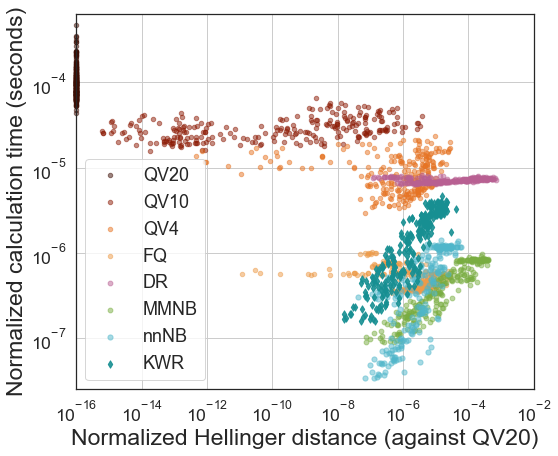

In [3]:
start = 0
stop = 256
fs = 23

fig, ax = plt.subplots(figsize=(8.2, 6.9))
cmap_quad = ("#3c0d03", "#8d1c06", "#e67424", "#ed9b49", "#f5c34d") #greek
cmap_ml = ( "#b86092", "#79ad41", "#4fb6ca", "#178f92", "#d7aca1") # austria, isfahan1 and isfahan2
# (dr,mmNB,nnNB,KWR,RW)
# cmap_ml = ("#d7aca1", "#ddc000", "#79ad41", "#34b6c6", "#4063a3") #isfahan2
#ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))

alpha=0.5

plt.scatter(compare_array_unnorm_hellinger[0,start:stop,1]+1e-16,compare_array_norm_hellinger[0,start:stop,0],
           label='QV20',s=20,c=cmap_quad[0],clip_on=False,alpha=alpha)
plt.scatter(compare_array_norm_hellinger[1,start:stop,1],compare_array_norm_hellinger[1,start:stop,0],
            label='QV10',s=20,c=cmap_quad[1],alpha=alpha)
plt.scatter(compare_array_norm_hellinger[2,start:stop,1],compare_array_norm_hellinger[2,start:stop,0],
            label='QV4',s=20,c=cmap_quad[2],alpha=alpha)
plt.scatter(compare_array_norm_hellinger[3,start:stop,1],compare_array_norm_hellinger[3,start:stop,0],
            label='FQ',s=20,c=cmap_quad[3],alpha=alpha)
plt.scatter(direct_hellinger_norm[start:stop],direct_times_norm[start:stop],
            label='DR',s=23,c=cmap_ml[0],alpha=alpha)
plt.scatter(compare_array_norm_hellinger[5,start:stop,1],compare_array_norm_hellinger[5,start:stop,0],
            label='MMNB',s=23,c=cmap_ml[1],alpha=alpha)
plt.scatter(compare_array_norm_hellinger[6,start:stop,1],compare_array_norm_hellinger[6,start:stop,0],
            label='nnNB',s=27,c=cmap_ml[2],alpha=0.5)
plt.scatter(compare_array_norm_hellinger[4,start:stop,1],compare_array_norm_hellinger[4,start:stop,0],
            label='KWR',s=27,c=cmap_ml[3],marker='d',alpha=0.9)


plt.xlabel('Normalized Hellinger distance (against QV20)',fontsize=fs)
plt.ylabel('Normalized calculation time (seconds)',fontsize=fs)
# plt.title("Timing vs. Hellinger Distance over Grid", fontdict={'fontsize': 20})
plt.grid()
plt.legend(fontsize=18)
plt.yscale('log')
plt.xscale('log')
xl = np.asarray([-16,-2],dtype=float)
yl = np.asarray([-7.6,-3.2],dtype=float)
plt.xlim(10**xl)
plt.ylim(10**yl)
plt.savefig('./figs/time_hellinger_scatter.png',dpi=450)

In [102]:
print(np.mean(compare_array_norm_hellinger[2,:,1]))
print(np.mean(compare_array_norm_hellinger[6,:,0]))

3.215746665926498e-06
5.782646994524489e-07


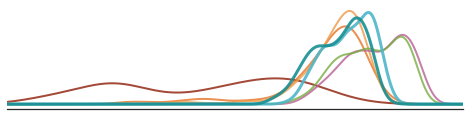

In [82]:
fig, ax = plt.subplots(figsize=(6.9, 2))

x_ = np.linspace(xl[0],xl[1],2000)
alpha = 0.8
for i in range(1,4):
    kde = scipy.stats.gaussian_kde(np.log10(compare_array_norm_hellinger[i,start:stop,1]))
    plt.plot(x_,kde(x_),color=cmap_quad[i],linewidth=2,alpha=alpha)
kde = scipy.stats.gaussian_kde(np.log10(direct_hellinger_norm[start:stop]))
plt.plot(x_,kde(x_),color=cmap_ml[0],linewidth=2,alpha=alpha)
kde = scipy.stats.gaussian_kde(np.log10(compare_array_norm_hellinger[5,start:stop,1]))
plt.plot(x_,kde(x_),color=cmap_ml[1],linewidth=2,alpha=alpha)
kde = scipy.stats.gaussian_kde(np.log10(compare_array_norm_hellinger[6,start:stop,1]))
plt.plot(x_,kde(x_),color=cmap_ml[2],linewidth=3,alpha=0.9)
kde = scipy.stats.gaussian_kde(np.log10(compare_array_norm_hellinger[4,start:stop,1]))
plt.plot(x_,kde(x_),color=cmap_ml[3],linewidth=3,alpha=0.9)
plt.xlim((xl))

plt.xticks([])
plt.yticks([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tight_layout()
plt.savefig('./figs/hellinger_kde.png',dpi=450,bbox_inches='tight')

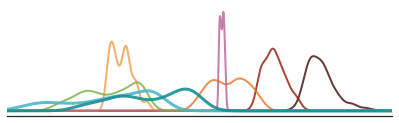

In [83]:
fig, ax = plt.subplots(figsize=(6.9, 2))

x_ = np.linspace(yl[0],yl[1],2000)
alpha = 0.8
for i in range(0,4):
    kde = scipy.stats.gaussian_kde(np.log10(compare_array_norm_hellinger[i,start:stop,0]))
    plt.plot(x_,kde(x_),color=cmap_quad[i],linewidth=2,alpha=alpha)
kde = scipy.stats.gaussian_kde(np.log10(direct_times_norm[start:stop]))
plt.plot(x_,0.35*kde(x_),color=cmap_ml[0],linewidth=2,alpha=alpha)
kde = scipy.stats.gaussian_kde(np.log10(compare_array_norm_hellinger[5,start:stop,0]))
plt.plot(x_,kde(x_),color=cmap_ml[1],linewidth=2,alpha=alpha)
kde = scipy.stats.gaussian_kde(np.log10(compare_array_norm_hellinger[6,start:stop,0]))
plt.plot(x_,kde(x_),color=cmap_ml[2],linewidth=3,alpha=0.9)
kde = scipy.stats.gaussian_kde(np.log10(compare_array_norm_hellinger[4,start:stop,0]))
plt.plot(x_,kde(x_),color=cmap_ml[3],linewidth=3,alpha=0.9)
plt.xlim(yl)

plt.xticks([])
plt.yticks([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.savefig('./figs/time_kde.png',dpi=450,bbox_inches = "tight")

### Figure 2b: Timing Over Grid

For 256 parameters! Not normalized. 



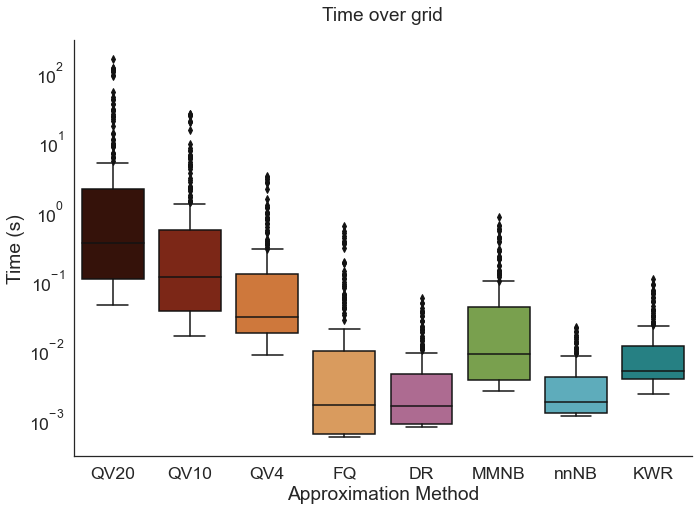

In [61]:
unnorm_time_data = {'Approximation Method': ['QV20']*256+ ['QV10']*256+ ['QV4']*256 + ['FQ']*256 +
                  ['DR']*256+['MMNB']*256+['nnNB']*256+['KWR']*256,
                  
        'Time (s)': np.concatenate((compare_array_unnorm_hellinger[0,:,0].flatten(),
                                 (compare_array_unnorm_hellinger[1,:,0].flatten()),
                                  (compare_array_unnorm_hellinger[2,:,0].flatten()),
                                   (compare_array_unnorm_hellinger[3,:,0].flatten()),
                                  (compare_array_unnorm_hellinger[5,:,0].flatten()),
                                    (direct_times_unnorm[0:256]),
                                    compare_array_unnorm_hellinger[6,:,0].flatten(),
                                    (compare_array_unnorm_hellinger[4,:,0].flatten()),
                                   )) }
unnorm_time_df = pd.DataFrame.from_dict(unnorm_time_data) 

# CHANGE to change colors
my_pal = {'QV20': cmap_quad[0],'QV10': cmap_quad[1],'QV4': cmap_quad[2],
          'FQ': cmap_quad[3], "KWR": cmap_ml[3], "MMNB": cmap_ml[1], "DR":cmap_ml[0],'RW':cmap_ml[4],'nnNB' : cmap_ml[2]}


g = sns.catplot(x="Approximation Method", y='Time (s)',kind="box",   data=unnorm_time_df,palette=my_pal,
               height=7, aspect=10/7)
g.set(yscale="log")
plt.title('Time over grid',fontsize=19);

plt.savefig('./figs/time_unnorm_box.png',dpi=450)

### Figure 2b: Hellinger Distances over PMF Grids

In [62]:
NN_hellinger = np.load('./results/NN_hellinger.npy')
NN_hellinger_1NB = np.load('./results/NN_hellinger_1NB.npy')
NB_hellinger = np.load('./results/NB_hellinger.npy')
rand_hellinger = np.load('./results/rand_hellinger.npy')
direct_hellinger_unnorm = np.load('./results/direct_model256_3_4t_hellinger_unnorm.npy')

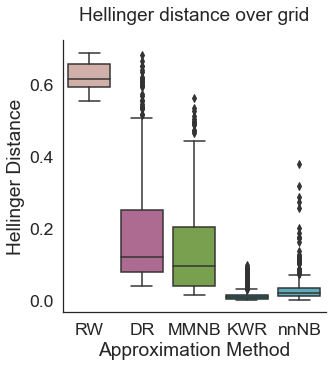

In [63]:
hellinger_data = {'Approximation Method': ['RW']*256*3+['DR']*256*3+ ['MMNB']*256*3+ ['KWR']*256*3+['nnNB']*256*3,
        'Hellinger Distance': np.concatenate((rand_hellinger,direct_hellinger_unnorm,NB_hellinger,NN_hellinger,
                                             NN_hellinger_1NB)) }



hellinger_df = pd.DataFrame.from_dict(hellinger_data) 

sns.catplot(x="Approximation Method", y='Hellinger Distance', kind="box",  data=hellinger_df,palette=my_pal)

plt.title('Hellinger distance over grid',fontsize=19);

plt.savefig('./figs/helldist_box.png',dpi=450)

### Figure 2c: Timing for single point

In [64]:
NN_times_onepoint = np.load('./results/NN_times_onepoint.npy')
NN_times_onepoint_1NB = np.load('./results/NN_times_onepoint_1NB.npy')
NB_times_onepoint = np.load('./results/NB_times_onepoint.npy')
direct_times_onepoint = np.load('./results/direct_model256_3_4t_times_onepoint.npy')
np.mean(NN_times_onepoint)
#np.mean(compare_array_unnorm_hellinger[4,:,0].flatten())
np.mean(NN_times_onepoint_1NB)

0.0007514761139949163

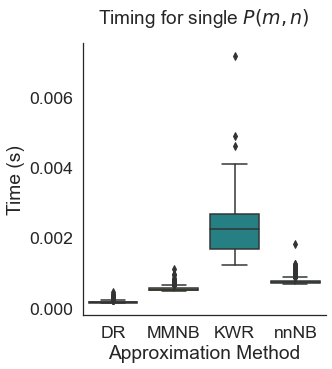

In [65]:
data_time = {'Approximation Method': ['DR']*256*3+['MMNB']*256*3+ ['KWR']*256*3+['nnNB']*256*3,
        'Time (s)': np.concatenate((direct_times_onepoint,NB_times_onepoint,NN_times_onepoint,NN_times_onepoint_1NB)) }

time_df = pd.DataFrame.from_dict(data_time) 

sns.catplot(x="Approximation Method", y='Time (s)', 
            kind="box",  data=time_df, palette = my_pal)
plt.title(r'Timing for single $P(m,n)$',fontsize=19);
plt.savefig('./figs/time_box.png',dpi=450)

### Figure 2d: Comparing PMFs

In [4]:
import nnNB_module

In [42]:
data_array = train.load_data(3,'./data/','256_test_full')

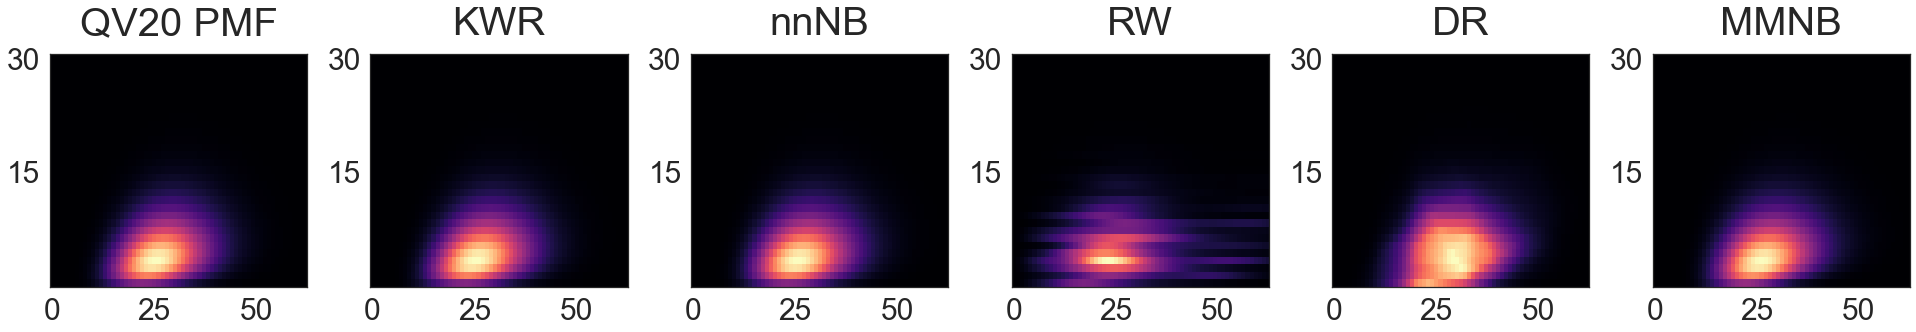

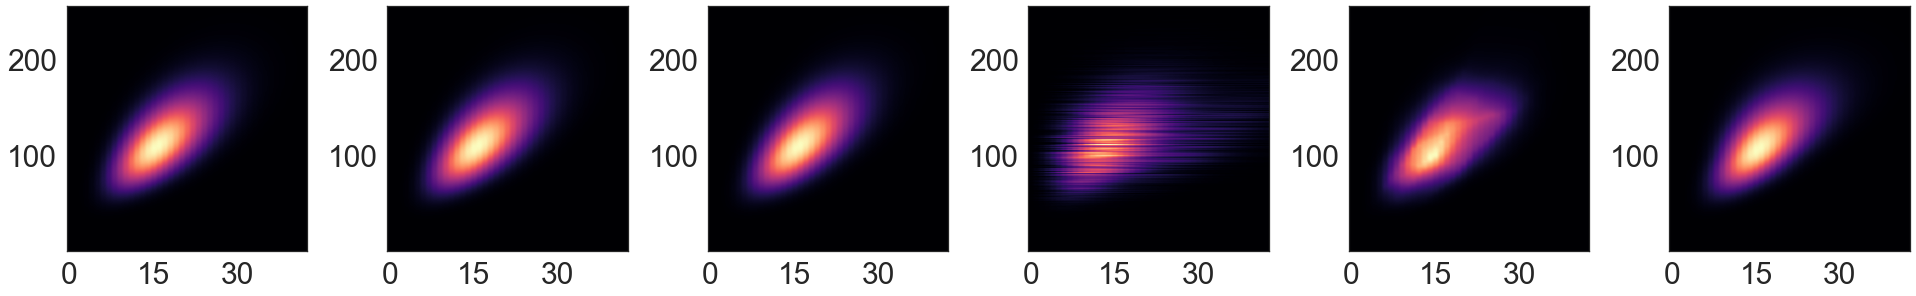

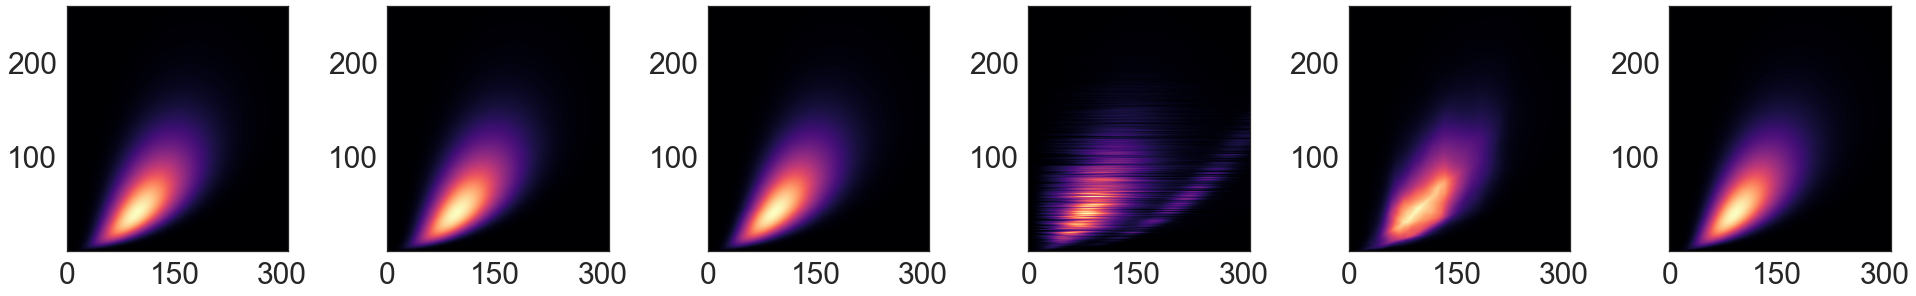

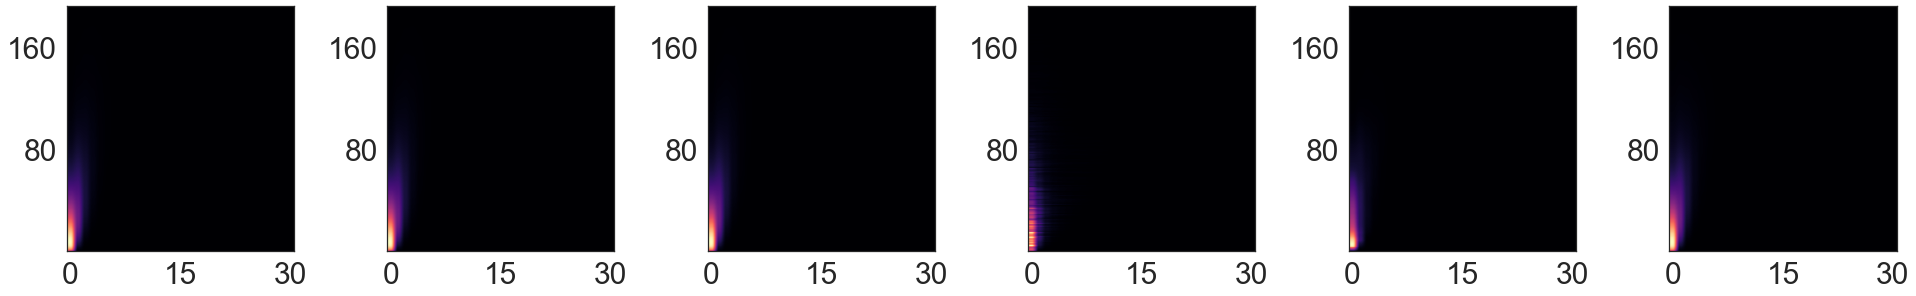

In [50]:
indices = [8,11,22,20]
cmap='magma'

matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

for index,i in enumerate(indices):
    

    pdf = data_array[i][1]
    p_in = data_array[i][0]

    nas_range = np.arange(pdf.shape[0])
    mat_range = np.arange(pdf.shape[1])

    predicted = ypm.get_prob(p_in,nas_range,mat_range,rand_weights=False)
    nnNB = nnNB_module.nnNB_prob(p_in,nas_range,mat_range)
    predicted_rand = ypm.get_prob(p_in,nas_range,mat_range,rand_weights=True)
    predicted_direct = direct.predict_pmf(p_in,nas_range[-1]+1,mat_range[-1]+1)
    N,M = np.meshgrid(range(pdf.shape[0]),range(pdf.shape[1]),indexing='ij')
    NB = ypm.approximate_conditional_tensorval(p_in,N,M).detach().numpy()
    
    
    
    if index == 0:
        fig1,ax1=plt.subplots(nrows=1,ncols=6,figsize=(27,5))
        ax1[0].set_title('QV20 PMF',fontsize=40)
        ax1[1].set_title('KWR',fontsize=40)
        ax1[2].set_title('nnNB',fontsize=40)
        ax1[3].set_title('RW',fontsize=40)
        ax1[4].set_title('DR',fontsize=40)
        ax1[5].set_title('MMNB',fontsize=40)
    
        
    else:
        fig1,ax1=plt.subplots(nrows=1,ncols=6,figsize=(27,4.5))
    
    # Create your ticker object with M ticks
    M = 3
    yticks = ticker.MaxNLocator(M)
    xticks = ticker.MaxNLocator(M)

    # set axis ticks
    ax1[0].yaxis.set_major_locator(yticks)
    ax1[0].xaxis.set_major_locator(xticks)
    ax1[1].yaxis.set_major_locator(yticks)
    ax1[1].xaxis.set_major_locator(xticks)
    ax1[2].yaxis.set_major_locator(yticks)
    ax1[2].xaxis.set_major_locator(xticks)
    ax1[3].yaxis.set_major_locator(yticks)
    ax1[3].xaxis.set_major_locator(xticks)
    ax1[4].yaxis.set_major_locator(yticks)
    ax1[4].xaxis.set_major_locator(xticks)
    ax1[5].yaxis.set_major_locator(yticks)
    ax1[5].xaxis.set_major_locator(xticks)
    
    # hide the 0 value
    ax1[0].yaxis.get_major_ticks()[1].label1.set_visible(False)
    ax1[1].yaxis.get_major_ticks()[1].label1.set_visible(False)
    ax1[2].yaxis.get_major_ticks()[1].label1.set_visible(False)
    ax1[3].yaxis.get_major_ticks()[1].label1.set_visible(False)
    ax1[4].yaxis.get_major_ticks()[1].label1.set_visible(False)
    ax1[5].yaxis.get_major_ticks()[1].label1.set_visible(False)

    

    ax1[0].imshow(pdf,aspect='auto',cmap=cmap)
    ax1[0].invert_yaxis()


    hell = tools.hellinger(pdf,predicted)
    ax1[1].imshow(predicted,aspect='auto',cmap=cmap)
    ax1[1].invert_yaxis()
    
    hell = tools.hellinger(pdf,nnNB)
    ax1[2].imshow(nnNB,aspect='auto',cmap=cmap)
    ax1[2].invert_yaxis()

    hell_NB = tools.hellinger(pdf,predicted_rand)
    ax1[3].imshow(predicted_rand,aspect='auto',cmap=cmap)
    ax1[3].invert_yaxis()


    hell_rand = tools.hellinger(pdf,predicted_direct)
    ax1[4].imshow(predicted_direct,aspect='auto',cmap=cmap)
    ax1[4].invert_yaxis()


    hell_direct = tools.hellinger(pdf,NB)
    ax1[5].imshow(NB,aspect='auto',cmap=cmap)
    ax1[5].invert_yaxis()

    plt.tight_layout()
    plt.savefig('./figs/pmf{:.0f}.png'.format(index),dpi=450,transparent=True)
    # plt.show()

-----

# Figure 3


### Figure 3a: Training/validation loss for final model

In [124]:
best_model_loss = np.load('./models/best_model_meta.npy',allow_pickle=True)

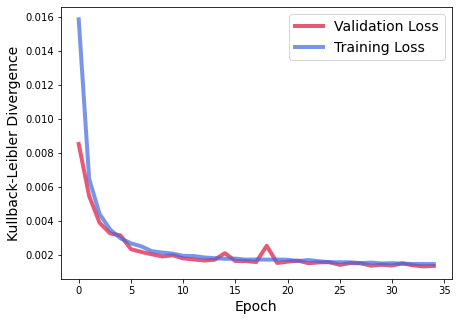

In [125]:
fig = plt.figure(figsize=(7,5))

best_model_loss = np.load('./models/best_model_meta.npy',allow_pickle=True)
train_klds = best_model_loss[2]
valid_klds = best_model_loss[3]

lw=4
alpha=0.7

plt.plot(valid_klds,label='Validation Loss',c='crimson',linewidth=lw,alpha=alpha)
plt.plot(train_klds,label='Training Loss',c='royalblue',linewidth=lw,alpha=alpha)
plt.legend(fontsize=fs)
# plt.title('Training and Validation Loss, Final Model',fontsize=fs)
plt.ylabel('Kullback-Leibler Divergence',fontsize=fs)
plt.xlabel('Epoch',fontsize=fs);
plt.savefig('./figs/kld_epoch.png',dpi=450)

### Figure 3b: Timing for training 

Training time for a varying number of *conditional examples* with 5, 10, or 20 kernel functions. 

In [126]:
times_5npdf = np.load('./results/timing_5npdf.npy')
times_10npdf = np.load('./results/timing_10npdf.npy')
times_20npdf = np.load('./results/timing_20npdf.npy')

In [244]:
num_conditionals = times_5npdf[0,:]
slope5, intercept5, r, p, se = scipy.stats.linregress(np.log10(num_conditionals), np.log10(times_5npdf[1,:]))
slope10, intercept10, r, p, se = scipy.stats.linregress(np.log10(num_conditionals), np.log10(times_10npdf[1,:]))
slope20, intercept20, r, p, se = scipy.stats.linregress(np.log10(num_conditionals), np.log10(times_20npdf[1,:]))

In [245]:
print(slope5,slope10,slope20)

0.9092209786955752 0.8636967104815387 0.8593145178250395


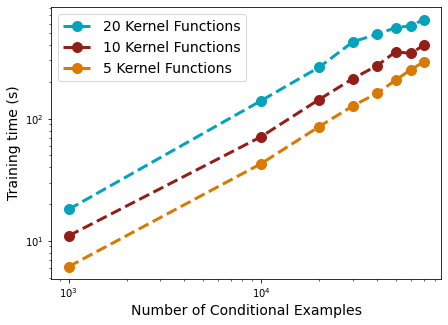

In [236]:
fig = plt.figure(figsize=(7,5))
num_conditionals = times_5npdf[0,:]
# col = ("#a40000", "#16317d", "#007e2f", "#ffcd12", "#b86092", "#721b3e", "#00b7a7")
col=("#04a3bd", "#f0be3d", "#931e18", "#da7901", "#247d3f", "#20235b")
lw=3
markersize=10
plt.plot(num_conditionals,times_20npdf[1,:],label='20 Kernel Functions',c=col[0],marker='o',linestyle='--',linewidth=lw,markersize=markersize)
plt.plot(num_conditionals,times_10npdf[1,:],label='10 Kernel Functions',c=col[2],marker='o',linestyle='--',linewidth=lw,markersize=markersize)
plt.plot(num_conditionals,times_5npdf[1,:],label='5 Kernel Functions',c=col[3],marker='o',linestyle='--',linewidth=lw,markersize=markersize)



#plt.plot(num_conditionals,num_conditionals*slope+intercept,label='Fitting num_cond vs. time for 10',c='lightgray',marker='o',linestyle='--',linewidth=lw,markersize=markersize)

# plt.title('Training Time vs. Number of Conditional Examples (1 Epoch)')
plt.xlabel('Number of Conditional Examples',fontsize=fs)
plt.ylabel('Training time (s)',fontsize=fs)
plt.legend(fontsize=fs)
plt.xscale('log')
plt.yscale('log')
plt.savefig('./figs/time_numex.png',dpi=450)

### Figure 3c-e: Varying Nodes, Kernel Functions, Examples
Plot the 5th, 95th percentile and mean Kullback-Leibler divergence for the testing parameters (stored in ./data/256_test_i.npy) as a function of changing the number of hidden nodes in the two hidden layers, the number of kernel functions, and the number of training parameters. 

In [128]:
klds_hid = np.load('./results/testing_klds_hid.npy',allow_pickle=True)
klds_npdf = np.load('./results/testing_klds_npdf.npy',allow_pickle=True)
klds_param = np.load('./results/testing_klds_param.npy',allow_pickle=True)

In [129]:
# get mean and quantiles for best model 
main_mean = np.mean(klds_param[-1,1])
main_95th = np.percentile(klds_param[-1,1],95)
main_5th = np.percentile(klds_param[-1,1],5)

### Figure 3c: Varying Nodes in Hidden Layers

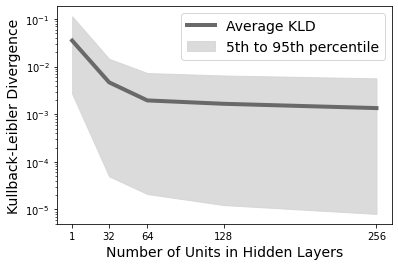

In [130]:
hid_95th = [ np.percentile(hid[1],95) for hid in klds_hid ] 
hid_5th = [ np.percentile(hid[1],5) for hid in klds_hid ] 
hid_means =  [ np.mean(hid[1]) for hid in klds_hid ] 


# add for best model
hid_units = [hid[0] for hid in klds_hid]
hid_units.append(256)
hid_means.append(main_mean)
hid_95th.append(main_95th)
hid_5th.append(main_5th)


lw=4
fig, ax = plt.subplots()
ax.plot(hid_units[:], hid_means[:], '-',label='Average KLD',color='dimgray',linewidth=lw)
ax.fill_between(hid_units[:], hid_95th[:], hid_5th[:], alpha=0.8, label = '5th to 95th percentile',color='lightgray')
# plt.title('KLD vs. Number of Units in Hidden Layers')
plt.ylabel('Kullback-Leibler Divergence',fontsize=fs)
plt.xlabel('Number of Units in Hidden Layers',fontsize=fs)
plt.xticks(hid_units[:], hid_units[:])
plt.yscale('log')
plt.legend(fontsize=fs)

#plt.savefig('./figs/kld_nunits.png',dpi=450)

### Figure 3d: Varying Number of Kernel Functions

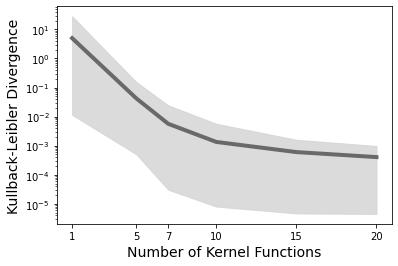

In [131]:
npdf = [ p[0] for p in klds_npdf]
npdf.insert(3,10)

npdf_95th = [ np.percentile(p[1],95) for p in klds_npdf ] 
npdf_95th.insert(3,main_95th)
npdf_5th = [ np.percentile(p[1],5) for p in klds_npdf] 
npdf_5th.insert(3,main_5th)
npdf_means =  [ np.mean(p[1]) for p in klds_npdf ] 
npdf_means.insert(3,main_mean)

npdf = [ p[0] for p in klds_npdf]
npdf.insert(3,10)


fig, ax = plt.subplots()
ax.plot(npdf[:], npdf_means[:], '-',label='Average KLD',color='dimgray',linewidth=lw)
ax.fill_between(npdf[:], npdf_95th[:], npdf_5th[:], alpha=0.8, label = '5th to 95th percentile',color='lightgray')
# plt.title('KLD vs. Number of Basis Functions')
plt.ylabel('Kullback-Leibler Divergence',fontsize=fs)
plt.xlabel('Number of Kernel Functions',fontsize=fs)
plt.xticks(npdf[:], npdf[:])
plt.yscale('log')
# plt.legend(fontsize=fs)

plt.savefig('./figs/kld_nkernels.png',dpi=450)

### Figure 3e: Varying Number of Example Rate Vectors

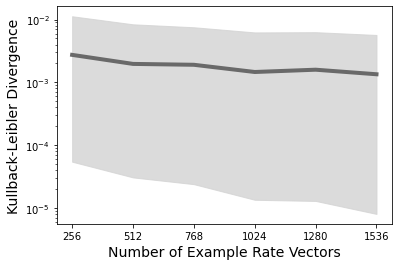

In [132]:
param_95th = [ np.percentile(p[1],95) for p in klds_param ] 
param_5th = [ np.percentile(p[1],5) for p in klds_param ] 
param_means =  [ np.mean(p[1]) for p in klds_param ] 


params = 256*(np.arange(6)+1)

fig, ax = plt.subplots()
ax.plot(params[:], param_means[:], '-',label='Average KLD',color='dimgray',linewidth=lw)
ax.fill_between(params[:], param_95th[:], param_5th[:], alpha=0.8, label = '5th to 95th percentile',color='lightgray')
# plt.title('KLD vs. Number of Examples')
plt.ylabel('Kullback-Leibler Divergence',fontsize=fs)
plt.xlabel('Number of Example Rate Vectors',fontsize=fs)
plt.xticks(params[:], params[:])
#plt.ylim(-0.001,0.02)
plt.yscale('log')
# plt.legend(fontsize=fs)

plt.savefig('./figs/kld_numex.png',dpi=450)


# Supplementary Tables and Figures


### Table 1: Model parameters

Parameters for final kernel weight regression models.

In [18]:
summary(ypm.model);

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            2,048
├─Linear: 1-2                            65,792
├─Linear: 1-3                            2,570
├─Linear: 1-4                            257
├─Softmax: 1-5                           --
Total params: 70,667
Trainable params: 70,667
Non-trainable params: 0


### Table 2: DR Model Params

Parameters for final direct regression model.


In [19]:
summary(direct.model_direct);

Layer (type:depth-idx)                   Param #
├─ModuleList: 1-1                        --
|    └─Linear: 2-1                       1,536
|    └─Linear: 2-2                       65,792
|    └─Linear: 2-3                       65,792
|    └─Linear: 2-4                       257
Total params: 133,377
Trainable params: 133,377
Non-trainable params: 0


### Table 3: nnNB Model Params

In [8]:
summary(nnNB_module.model1.parameters);

<bound method Module.parameters of MLP_1NB_varmax(
  (softplus): Softplus(beta=1, threshold=20)
  (module_list): ModuleList(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=2, bias=True)
  )
)>

### S2: Direct Regression Hellinger Distances

Comparing varying number of hidden nodes and layers in direct regression. 

In [134]:
test_hellinger_nodes_d = np.load('./results/testing_hellinger_direct_vary_nodes.npy',allow_pickle=True)
test_hellinger_layers_d = np.load('./results/testing_hellinger_direct_vary_layers.npy',allow_pickle=True)

In [135]:
# Calculate percentiles for hellinger distances for changing number of nodes

nodes = [128,256,512,1024,3000]

nodes_95th = [ np.percentile(h,95) for h in test_hellinger_nodes_d ] 
nodes_5th = [ np.percentile(h,5) for h in test_hellinger_nodes_d ] 
nodes_means =  [ np.mean(h) for h in test_hellinger_nodes_d ] 

layers = [2,3,4,5]

# Calculate percentiles for hellinger distances for changing number of layers
layers_95th = [ np.percentile(h,95) for h in test_hellinger_layers_d ] 
layers_5th = [ np.percentile(h,5) for h in test_hellinger_layers_d ] 
layers_means =  [ np.mean(h) for h in test_hellinger_layers_d ] 

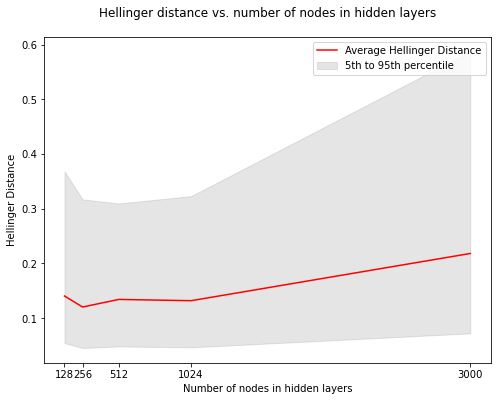

In [136]:
# and plot
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(nodes, nodes_means, '-',label='Average Hellinger Distance',c='red')
ax.fill_between(nodes, nodes_95th, nodes_5th, alpha=0.2, label = '5th to 95th percentile',color='gray')
plt.title('Hellinger distance vs. number of nodes in hidden layers')
plt.ylabel('Hellinger Distance')
plt.xlabel('Number of nodes in hidden layers')
plt.xticks(nodes[:], nodes[:])
plt.legend();
plt.savefig('./figs/direct_vary_nodes.png',dpi=450)

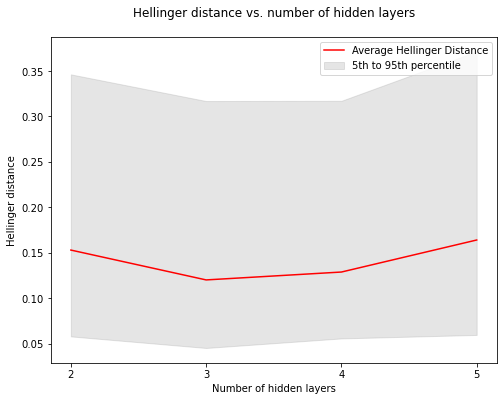

In [137]:
# and plot
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(layers, layers_means, '-',label='Average Hellinger Distance',c='red')
ax.fill_between(layers, layers_95th, layers_5th, alpha=0.2, label = '5th to 95th percentile',color='gray')
plt.title('Hellinger distance vs. number of hidden layers')
plt.ylabel('Hellinger distance')
plt.xlabel('Number of hidden layers')
plt.xticks(layers[:], layers[:])
plt.legend()
plt.savefig('./figs/direct_vary_layers.png',dpi=450);

### S3: Unnormalized grid evalution

Comparing time to calculate over grids of various sizes.

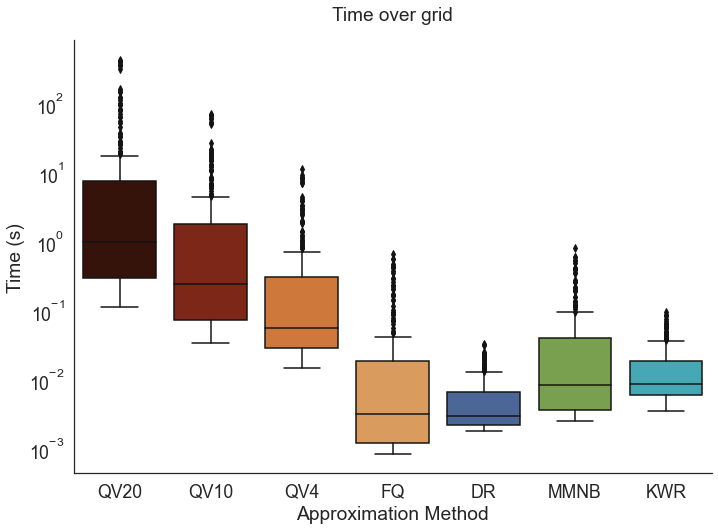

In [15]:
unnorm_time_data = {'Approximation Method': ['QV20']*256+ ['QV10']*256+ ['QV4']*256 + ['FQ']*256 +
                  ['DR']*256+['MMNB']*256+['KWR']*256,
                  
        'Time (s)': np.concatenate((compare_array_unnorm_hellinger[0,:,0].flatten(),
                                 (compare_array_unnorm_hellinger[1,:,0].flatten()),
                                  (compare_array_unnorm_hellinger[2,:,0].flatten()),
                                   (compare_array_unnorm_hellinger[3,:,0].flatten()),
                                  (compare_array_unnorm_hellinger[5,:,0].flatten()),
                                    (direct_times_unnorm[0:256]),
                                    (compare_array_unnorm_hellinger[4,:,0].flatten()),
                                   )) }
unnorm_time_df = pd.DataFrame.from_dict(unnorm_time_data) 

# CHANGE to change colors
my_pal = {'QV20': cmap_quad[0],'QV10': cmap_quad[1],'QV4': cmap_quad[2],
          'FQ': cmap_quad[3], "KWR": cmap_ml[3], "MMNB": cmap_ml[2], "DR":cmap_ml[4],'RW':cmap_ml[0]}


g = sns.catplot(x="Approximation Method", y='Time (s)',kind="box",   data=unnorm_time_df,palette=my_pal,
               height=7, aspect=10/7)
g.set(yscale="log")
plt.title('Time over grid',fontsize=19);

plt.savefig('./figs/time_unnorm_box.png',dpi=450)